# Create phyloseq object

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/'
biomFileDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/OTU_binning/'

biomFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/ERA/ERA_Metadata.txt'
plotdataFile = '/home/bryan/ERA/MasterLong.csv'
mappingFile = '/home/bryan/ERA/ERA_MappingFile.txt'
treeFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/fasttree/otusn_pick_lad.nwk'

# Init

In [2]:
import os

In [3]:
%load_ext rpy2.ipython

In [4]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [5]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: iterators

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:gridExtra’:

    combine


  warnings.w

# Read in metadata files

In [6]:
%%R -i plotdataFile
data = read.csv(plotdataFile, header = TRUE)
data %>% head

  Rep Row Pos Fert PlotIndex   PlotID Plant Genotype SeedTreatment R_Year ERA
1   1   3   a   85        25  1-3a_85  1936     1936       Treated   1936   1
2   1   3   a    0        26   1-3a_0  1936     1936       Treated   1936   1
3   1   3   a  170        27 1-3a_170  1936     1936       Treated   1936   1
4   2   5   b  170       112 2-5b_170  1936     1936       Treated   1936   1
5   2   5   b   85       113  2-5b_85  1936     1936       Treated   1936   1
6   2   5   b    0       114   2-5b_0  1936     1936       Treated   1936   1
  BG_activity.g BX_activity.g CB_activity.g LAP_activity.g NAG_activity.g
1            NA            NA            NA             NA             NA
2            NA            NA            NA             NA             NA
3            NA            NA            NA             NA             NA
4            NA            NA            NA             NA             NA
5            NA            NA            NA             NA             NA
6         

In [7]:
%%R -i mappingFile
Map = read.delim(mappingFile, header = TRUE, sep = "\t")
head(Map)

       X.sampleID TubeID ExtractionPlate PooledDNAPlate Sample.Well.ID
1 ERA-T1_1-2b_170    125            ERA1              A             A1
2 ERA-T1_1-3c_170    137            ERA1              A             B1
3   ERA-T3_1-2b_0    530            ERA1              A             C1
4  ERA-T2_1-2b_85    361            ERA1              A             D1
5 ERA-T3_1-2d_170    602            ERA1              A             E1
6  ERA-T1_1-4b_85    143            ERA1              A             F1
  PrimerPlate Primer.Number Primer.Well.ID  X primerFwdLoc primerRevLoc
1           1             1             A1 NA          1-A          1-1
2           1             2             B1 NA          1-B          1-1
3           1             3             C1 NA          1-C          1-1
4           1             4             D1 NA          1-D          1-1
5           1             5             E1 NA          1-E          1-1
6           1             6             F1 NA          1-F          1-1

In [8]:
%%R
Map[Map$TubeID %in% c("390", "545"),] 

        X.sampleID TubeID ExtractionPlate PooledDNAPlate Sample.Well.ID
79  ERA-T2_2-1d_85    390            ERA2              A            G10
80 ERA-T3_2-5c_170    545            ERA2              A            H10
   PrimerPlate Primer.Number Primer.Well.ID  X primerFwdLoc primerRevLoc
79           1            79            G10 NA          1-G         1-10
80           1            80            H10 NA          1-H         1-10
   fwd_barcode rev_barcode   PlotID TimePoint
79    GGATATCT    TAGCAGAC  2-1d_85        T2
80    GACACCGT    TAGCAGAC 2-5c_170        T3


* mapping file has been fixed

In [9]:
%%R
SampleData = inner_join(Map, data, by = c("PlotID", "TimePoint"))
dim(SampleData) %>% print
SampleData %>% head

[1] 244  46
       X.sampleID TubeID ExtractionPlate PooledDNAPlate Sample.Well.ID
1 ERA-T1_1-2b_170    125            ERA1              A             A1
2 ERA-T1_1-3c_170    137            ERA1              A             B1
3   ERA-T3_1-2b_0    530            ERA1              A             C1
4  ERA-T2_1-2b_85    361            ERA1              A             D1
5 ERA-T3_1-2d_170    602            ERA1              A             E1
6  ERA-T1_1-4b_85    143            ERA1              A             F1
  PrimerPlate Primer.Number Primer.Well.ID  X primerFwdLoc primerRevLoc
1           1             1             A1 NA          1-A          1-1
2           1             2             B1 NA          1-B          1-1
3           1             3             C1 NA          1-C          1-1
4           1             4             D1 NA          1-D          1-1
5           1             5             E1 NA          1-E          1-1
6           1             6             F1 NA          1-F 

In [10]:
%%R
# Check duplicate names
SampleData %>% 
    group_by(X.sampleID,PlotID, TimePoint) %>%
    summarise(Num = length(BG_activity.g)) %>%
    ungroup() %>%
    filter(Num > 1) %>% 
   select(PlotID, TimePoint)

# A tibble: 0 × 2
# ... with 2 variables: PlotID <chr>, TimePoint <chr>


* Duplicates fixed!

In [11]:
%%R
data %>%
    filter(PlotID %in% c("2-3b_170", "4-5b_170") & TimePoint %in% c("T1", "T3"))

  Rep Row Pos Fert PlotIndex   PlotID Plant Genotype SeedTreatment R_Year ERA
1   4   5   b  170       232 4-5b_170  2001     2001       Treated   2001   3
2   4   5   b  170       232 4-5b_170  2001     2001       Treated   2001   3
3   2   3   b  170        88 2-3b_170  Bare     Bare                   NA  NA
4   2   3   b  170        88 2-3b_170  Bare     Bare                   NA  NA
  BG_activity.g BX_activity.g CB_activity.g LAP_activity.g NAG_activity.g
1      72.89345      17.18532      13.86478       30.43450       13.75206
2     153.19322      33.18853      41.66629      244.26208       35.50504
3      40.40948      11.38810      12.71309       23.24555       11.12396
4      64.08162      18.07281      20.44175      199.55173       13.71814
  TimePoint Stage kgdw_ha FracN.leco FracC.leco   kgN_ha        RGR       AGR
1        T1    V6  1317.6   0.022403    0.42341 29.51819 0.09206589  36.11667
2        T3    R3 15255.0   0.008775    0.43572 11.56194 0.02905348 342.45652
3     

In [12]:
# Write joined metadataFile

In [13]:
%%R
write.table(SampleData, file = '/home/bryan/ERA/ERA_Metadata.txt', row.names = FALSE, sep = '\t')

# Create phyloseq objects

In [14]:
%%R -i biomFile -i mappingFile -i workDir -i treeFile
# Just controls
# loading
setwd(workDir)

## biom file
physeq = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(mappingFile)
physeq = merge_phyloseq(physeq,sample.data)
physeq.controls = subset_samples(physeq, !TimePoint %in% c("T0", "T1", "T2", "T3"), TRUE)
physeq.controls

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13919 taxa and 9 samples ]
sample_data() Sample Data:       [ 9 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 13919 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 13919 tips and 13918 internal nodes ]


In [15]:
%%R
saveRDS(physeq.controls, '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/controls.rds')

In [16]:
%%R
sample_names(physeq.controls)

[1] "MockComm"         "PostiveControl_C" "NegControl_Plate" "NegControl_A"    
[5] "NegControl_B"     "PosControl_B"     "PosControl_A"     "NegControl_C"    
[9] "IndexQC_Rev"     


In [17]:
%%R
sample_data

standardGeneric for "sample_data" defined from package "phyloseq"

function (object, errorIfNULL = TRUE) 
standardGeneric("sample_data")
<environment: 0xbe1f838>
Methods may be defined for arguments: object, errorIfNULL
Use  showMethods("sample_data")  for currently available ones.


In [18]:
%%R
sample_names(physeq)

  [1] "ERA-T0_2-2c_0"    "ERA-T2_3-1d_85"   "ERA-T1_3-5c_170" 
  [4] "ERA-T2_1-5a_85"   "ERA-T1_1-2b_170"  "ERA-T1_1-4b_0"   
  [7] "ERA-T1_4-3d_0"    "ERA-T1_1-4a_170"  "ERA-T3_1-3c_170" 
 [10] "ERA-T1_4-4a_170"  "ERA-T1_2-2b_85"   "ERA-T3_3-1c_0"   
 [13] "ERA-T2_2-2d_85"   "ERA-T1_1-2d_170"  "ERA-T1_1-3c_85"  
 [16] "ERA-T3_3-4c_170"  "ERA-T2_1-3d_85"   "ERA-T2_4-3c_85"  
 [19] "ERA-T1_1-2d_85"   "ERA-T3_3-2c_170"  "ERA-T3_4-3d_85"  
 [22] "ERA-T0_1-5a_0"    "ERA-T3_2-5a_170"  "ERA-T3_3-1a_170" 
 [25] "ERA-T1_1-3c_170"  "ERA-T2_1-2b_85"   "ERA-T3_2-2b_85"  
 [28] "ERA-T2_1-2d_85"   "ERA-T3_4-1b_85"   "ERA-T3_2-5a_0"   
 [31] "ERA-T1_4-1b_0"    "ERA-T3_1-4a_0"    "ERA-T3_1-2d_0"   
 [34] "ERA-T2_1-3c_85"   "ERA-T3_2-5a_85"   "ERA-T1_3-1d_85"  
 [37] "ERA-T3_1-4a_170"  "ERA-T3_1-2c_0"    "ERA-T1_4-3b_0"   
 [40] "ERA-T1_1-2c_170"  "ERA-T3_1-5a_85"   "ERA-T1_3-1d_170" 
 [43] "ERA-T1_3-5c_0"    "ERA-T2_1-4a_85"   "ERA-T1_2-3d_170" 
 [46] "ERA-T1_4-3d_85"   "ERA-T1_4-1b_85"   "ERA-T1_2-5

In [19]:
%%R -i biomFile -i metadataFile -i workDir -i treeFile
# ERA dataset
# loading
setwd(workDir)

## biom file
physeq.era = import_biom(biomFile, treeFile)

## loading sample metadata
sample.data = import_qiime_sample_data(metadataFile)
physeq.era = merge_phyloseq(physeq.era,sample.data)

In [20]:
%%R
physeq.era

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13919 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 13919 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 13919 tips and 13918 internal nodes ]


In [21]:
%%R
head(sample_data(physeq.era))

Sample Data:        [6 samples by 46 sample variables]:
                     X.sampleID  TubeID ExtractionPlate PooledDNAPlate
ERA-T0_2-2c_0     ERA-T0_2-2c_0 BD - 26            ERA3              C
ERA-T2_3-1d_85   ERA-T2_3-1d_85     425            ERA4              B
ERA-T1_3-5c_170 ERA-T1_3-5c_170     213            ERA4              B
ERA-T2_1-5a_85   ERA-T2_1-5a_85     382            ERA3              C
ERA-T1_1-2b_170 ERA-T1_1-2b_170     125            ERA1              A
ERA-T1_1-4b_0     ERA-T1_1-4b_0     144            ERA1              A
                Sample.Well.ID PrimerPlate Primer.Number Primer.Well.ID  X
ERA-T0_2-2c_0               B7           3            29             E4 NA
ERA-T2_3-1d_85              E5           2            37             E5 NA
ERA-T1_3-5c_170             D3           2            20             D3 NA
ERA-T2_1-5a_85              D5           3            16             H2 NA
ERA-T1_1-2b_170             A1           1             1             A1 

# Filter and partition

* Following: 
Callahan BJ, Sankaran K, Fukuyama JA et al. Bioconductor Workflow for Microbiome Data Analysis: from raw reads to community analyses [version 2; referees: 3 approved]. F1000Research 2016, 5:1492 (doi: 10.12688/f1000research.8986.2)

## Remove taxa with unassigned higher ranks

In [23]:
%%R
table(tax_table(physeq.era)[, "Rank2"], exclude = NULL)


          __Acidobacteria          __Actinobacteria         __Armatimonadetes 
                      895                      1558                       210 
          __Bacteroidetes                   __BD1-5               __BHI80-139 
                      672                        19                         9 
__Candidate_division_BRC1  __Candidate_division_OD1 __Candidate_division_OP11 
                       60                       155                        30 
 __Candidate_division_OP3  __Candidate_division_SR1  __Candidate_division_TM7 
                       35                         3                        57 
 __Candidate_division_WS3              __Chlamydiae                __Chlorobi 
                      115                       229                        40 
            __Chloroflexi           __Cyanobacteria         __Deferribacteres 
                      964                       175                         1 
    __Deinococcus-Thermus           __Elusimicrobia

In [24]:
%%R
physeq.era <- subset_taxa(physeq.era, !is.na(Rank2))


# Do we need to rarify?

### check sequence counts

In [28]:
%%R
mdf = psmelt(physeq.era)

In [29]:
%%R
ss.df = mdf %>% group_by(Genotype, PlotID, TimePoint, Fert) %>%
    summarise(Reads = sum(Abundance))
mdf = NULL

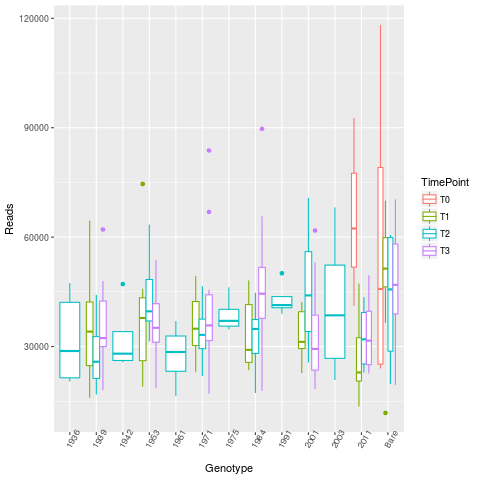

In [30]:
%%R
ggplot(ss.df, aes(x = Genotype, y = Reads, color = TimePoint)) +
    #geom_point(positition = position_dodge(0.4)) + 
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 60))

* Neither particular genotypes nor time points are dramatically underespresented in reads.  
* No need to rarify for now

## Filter

In [31]:
%%R 
# filtering/normalizing
physeq.thresh = filter_taxa(physeq.era, function(x) sum(x > 3) > 3, TRUE)
    
physeq.snorm = transform_sample_counts(physeq.thresh, function(x) x/sum(x))

physeq.snorm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4592 taxa and 243 samples ]
sample_data() Sample Data:       [ 243 samples by 46 sample variables ]
tax_table()   Taxonomy Table:    [ 4592 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4592 tips and 4591 internal nodes ]


In [32]:
%%R
saveRDS(physeq.thresh, '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds')
saveRDS(physeq.snorm, '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_snorm.rds') 
saveRDS(physeq.era, '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_full.rds')

# Session info

In [ ]:
%%R
sessionInfo()